In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip


# 1. train,test set 불러오기

In [2]:
pd.options.display.max_columns = 100

train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip", parse_dates = ["Date"])
test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip", parse_dates = ["Date"])

display(train.head(),test.head())

# ------------------추가사항----------------------

# 이상치(outlier) 처리하기
train = train[train["Weekly_Sales"] > -1100 ]
train = train[train["Weekly_Sales"] < 600000]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False



# 2. train set과 test set을 alldata로 묶어 data set의 전처리를 한번에 적용
-  문자열이 섞여있는 "Date" column을 새롭게 파싱
-  필요없는 columns 제거 ex)정답값

In [3]:
alldata = pd.concat([train,test])

# 날짜 Parsing
alldata["year"] = alldata["Date"].dt.year
alldata["month"] = alldata["Date"].dt.month
alldata["day"] = alldata["Date"].dt.day
alldata["week"] = alldata["Date"].dt.week

alldata

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day,week
0,1,1,2010-02-05,24924.50,False,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,2010,3,5,9
...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,NaN,False,2013,6,28,26
115060,45,98,2013-07-05,NaN,False,2013,7,5,27
115061,45,98,2013-07-12,NaN,False,2013,7,12,28
115062,45,98,2013-07-19,NaN,False,2013,7,19,29


# 3. 통계량 추가하기

> 통계량 정보를 추가를 하였으나 
1. 정답값과의 상관관계는 0.02이하로 매우 연관성이 낮고
2. 모델의 학습변수중요도를 확인한 후, 점수에 주는 영향이 없어서 주석처리 함 

In [4]:
# s_sale = alldata.groupby("Store")["Weekly_Sales"].agg(["mean","max","count"]).reset_index()
# s_sale = s_sale.rename(columns = {"mean":"s_mean","max":"s_max","count":"s_count"})
# alldata = pd.merge(alldata,s_sale,on="Store")

# d_sale = alldata.groupby("Dept")["Weekly_Sales"].agg(["mean","max","count"])
# d_sale = d_sale.rename(columns = {"mean":"d_mean","max":"d_max","count":"d_count"})
# alldata = pd.merge(alldata,d_sale,on="Dept")

# h_sale = alldata.groupby("IsHoliday")["Weekly_Sales"].agg(["mean","max","count"])
# h_sale = h_sale.rename(columns = {"mean":"h_mean","max":"h_max","count":"h_count"})
# alldata = pd.merge(alldata,h_sale,on="IsHoliday")

# y_sale = alldata.groupby("year")["Weekly_Sales"].agg(["mean","max","count"])
# y_sale = y_sale.rename(columns = {"mean":"y_mean","max":"y_max","count":"y_count"})
# alldata = pd.merge(alldata,y_sale,on="year")

# w_sale = alldata.groupby("month")["Weekly_Sales"].agg(["mean","max","count"])
# w_sale = w_sale.rename(columns = {"mean":"w_mean","max":"w_max","count":"w_count"})
# alldata = pd.merge(alldata,w_sale,on="month")

# alldata.corr()["Weekly_Sales"].sort_values(ascending = False)

In [5]:
alldata2 = alldata.drop(["Date","Weekly_Sales"],axis = 1)
alldata2.head()

,Store,Dept,IsHoliday,year,month,day,week
0,1,1,False,2010,2,5,5
1,1,1,True,2010,2,12,6
2,1,1,False,2010,2,19,7
3,1,1,False,2010,2,26,8
4,1,1,False,2010,3,5,9


# 4. 새로운 정보를 추가하기 위해 다른 파일 불러오기

1. feature.csv
> 각 Store의 날짜별 온도,연료값...등의 정보

2. store.csv
>  각 Store 별 type와 size의 정보

In [6]:
# 1.feature.csv

feature = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip")
feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
feature[feature["Date"]=="2010-02-05"]
# - 각각의 1부터 45의 Store 별로 하루치의 정보가 있음을 알 수 있다.

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
182,2,2010-02-05,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False
364,3,2010-02-05,45.71,2.572,NaN,NaN,NaN,NaN,NaN,214.424881,7.368,False
546,4,2010-02-05,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,False
728,5,2010-02-05,39.70,2.572,NaN,NaN,NaN,NaN,NaN,211.653972,6.566,False
910,6,2010-02-05,40.43,2.572,NaN,NaN,NaN,NaN,NaN,212.622352,7.259,False
1092,7,2010-02-05,10.53,2.580,NaN,NaN,NaN,NaN,NaN,189.381697,9.014,False
1274,8,2010-02-05,34.14,2.572,NaN,NaN,NaN,NaN,NaN,214.471451,6.299,False
1456,9,2010-02-05,38.01,2.572,NaN,NaN,NaN,NaN,NaN,214.655459,6.415,False
1638,10,2010-02-05,54.34,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,9.765,False


- feature.csv로부터 각 Store별 온도,연료값 등의 평균을 대표로 넣었으나
>  위의 통계량과 마찬가지로 정답값과의 상관관계가 낮고 모델에서 걸러져서 주석처리 함


In [8]:
# avg_temp = feature.groupby("Date")["Temperature"].mean().reset_index()
# avg_Fprice = feature.groupby("Date")["Fuel_Price"].mean().reset_index()

# alldata = pd.merge(alldata,avg_temp,on="Date", how="left")  
# alldata = pd.merge(alldata,avg_Fprice, on="Date",how="left")

# avg_feature = feature.drop(["IsHoliday","Store"],axis=1).groupby("Date").mean().reset_index()

# train = pd.merge(train,avg_feature,on="Date")

# train.corr()["Weekly_Sales"]
# train.head()

In [9]:
# 2.store.csv

store = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


- "Type"column은 store["Type"].unique()의 결과 A,B,C 3종류가 있으나, 
- 모델에 학습시키기 위해 RabelEncoding을 이용해 문자열 카테고리에서 숫자형 카테고리column으로 바꿈 (A,B,C -> 0,1,2 )

In [10]:
alldata2 = pd.merge(alldata2,store,on="Store",how="left")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

alldata2["Type"] = le.fit_transform(alldata2["Type"])
alldata2

,Store,Dept,IsHoliday,year,month,day,week,Type,Size
0,1,1,False,2010,2,5,5,0,151315
1,1,1,True,2010,2,12,6,0,151315
2,1,1,False,2010,2,19,7,0,151315
3,1,1,False,2010,2,26,8,0,151315
4,1,1,False,2010,3,5,9,0,151315
...,...,...,...,...,...,...,...,...,...
536620,45,98,False,2013,6,28,26,1,118221
536621,45,98,False,2013,7,5,27,1,118221
536622,45,98,False,2013,7,12,28,1,118221
536623,45,98,False,2013,7,19,29,1,118221


# 학습을 위해 alldata를 다시 train과 test set으로 분리

In [11]:
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

# 5. 시각화

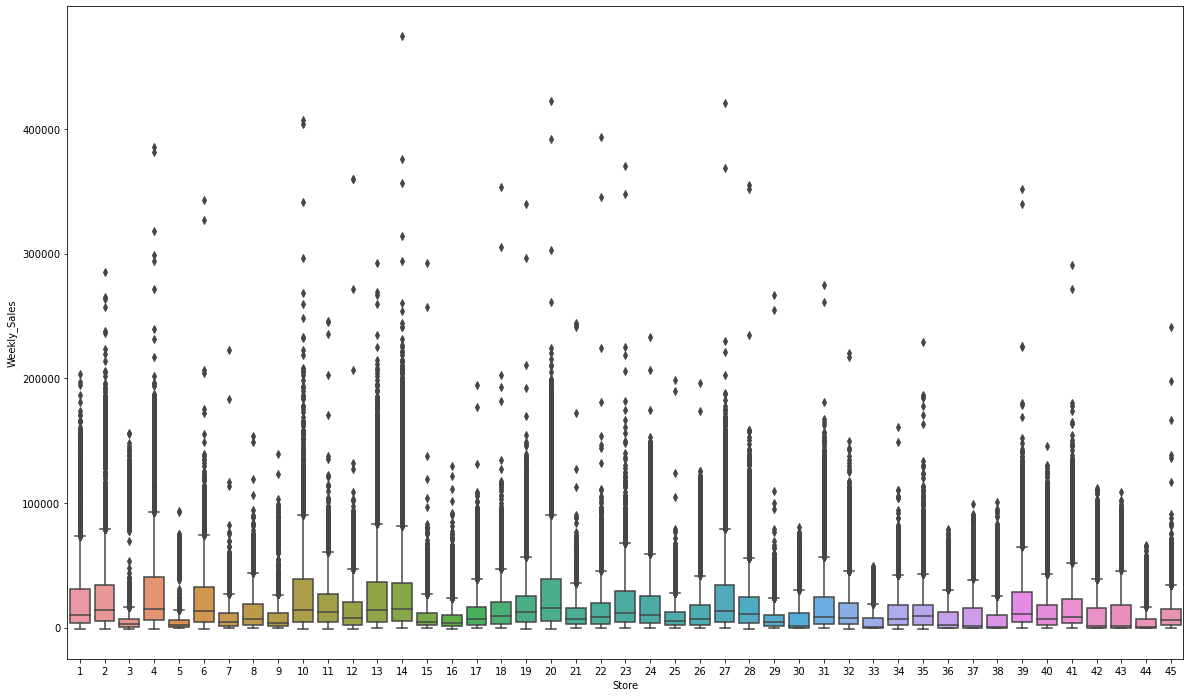

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 각 지점 별 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train["Store"],train["Weekly_Sales"])

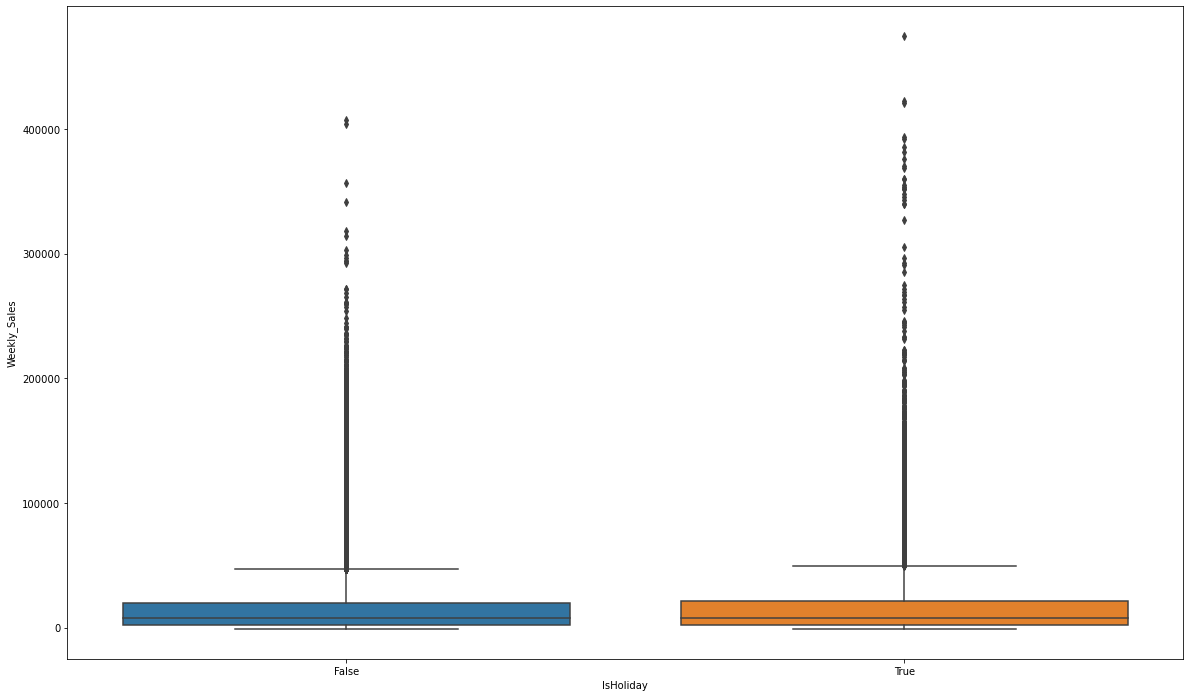

In [13]:
# 휴일의 유무에 따른 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train["IsHoliday"],train["Weekly_Sales"])

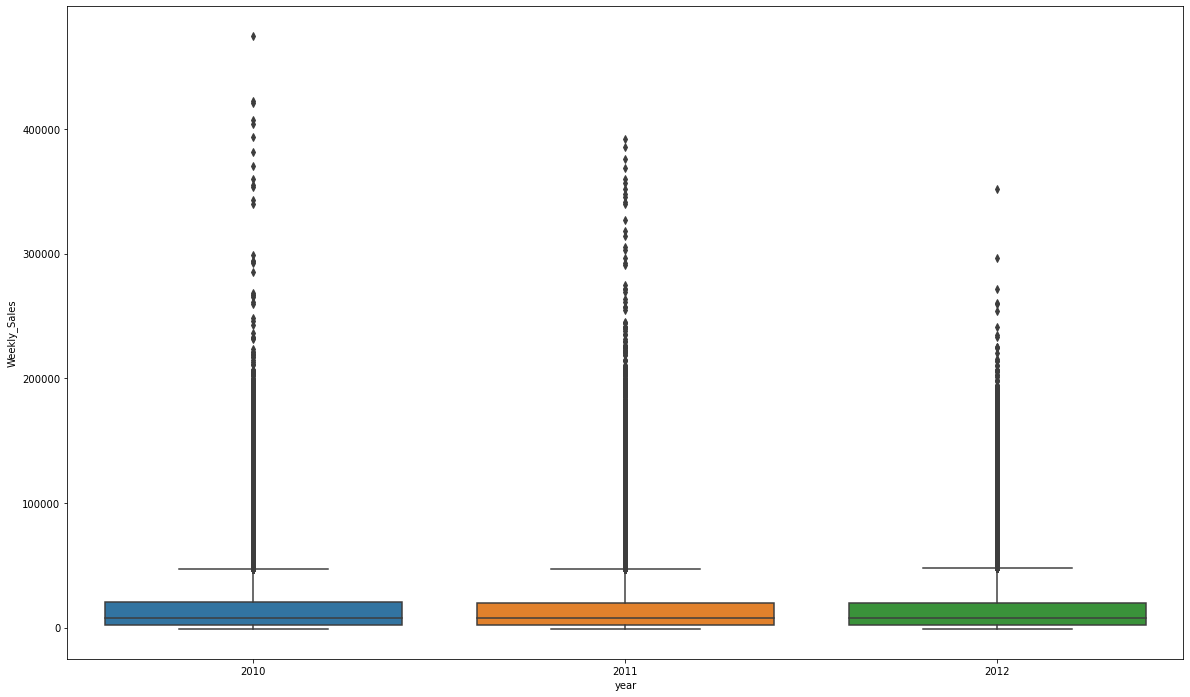

In [14]:
# 연도에 따른 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train2["year"],train["Weekly_Sales"])

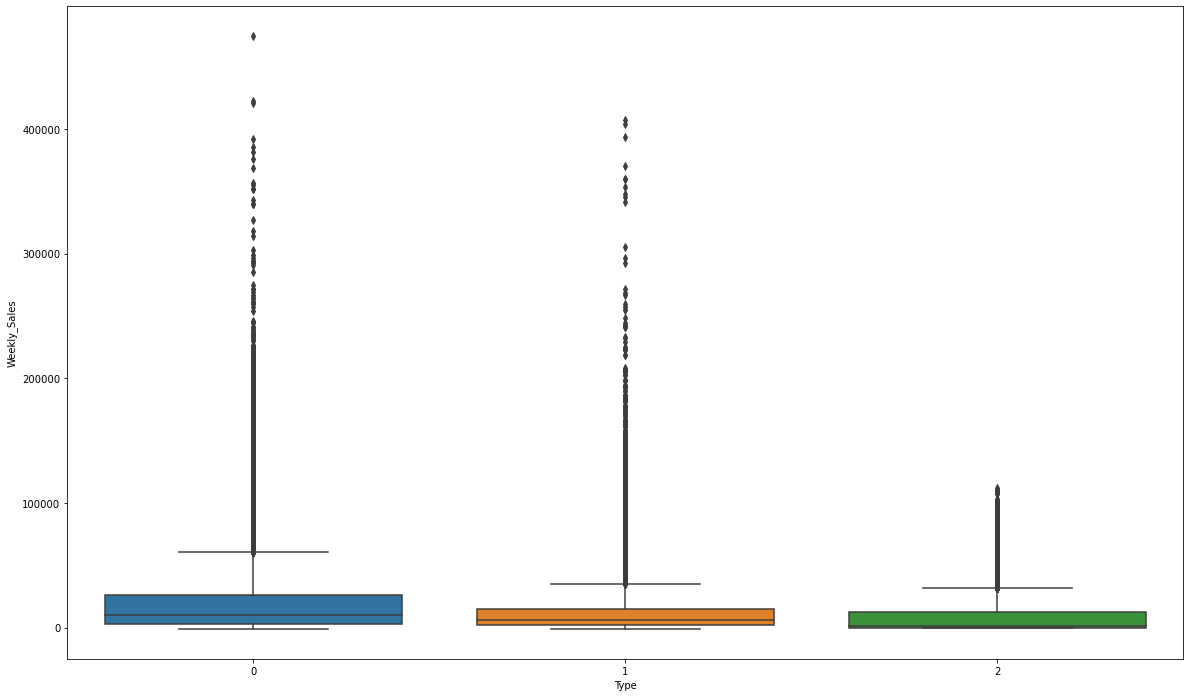

In [15]:
# 지점의 Type에 따른 판매량
plt.figure(figsize=(20,12))
sns.boxplot(train2["Type"],train["Weekly_Sales"])

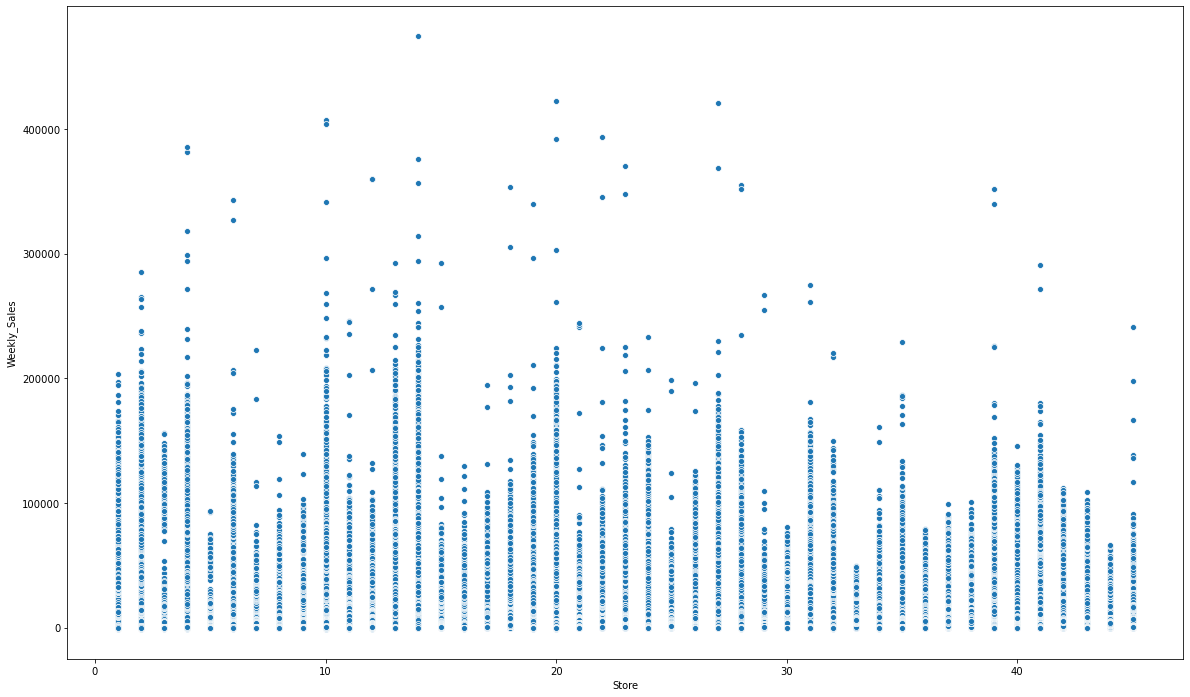

In [16]:
# 지점에 따른 판매량
plt.figure(figsize=(20,12))
sns.scatterplot(train2["Store"],train["Weekly_Sales"])

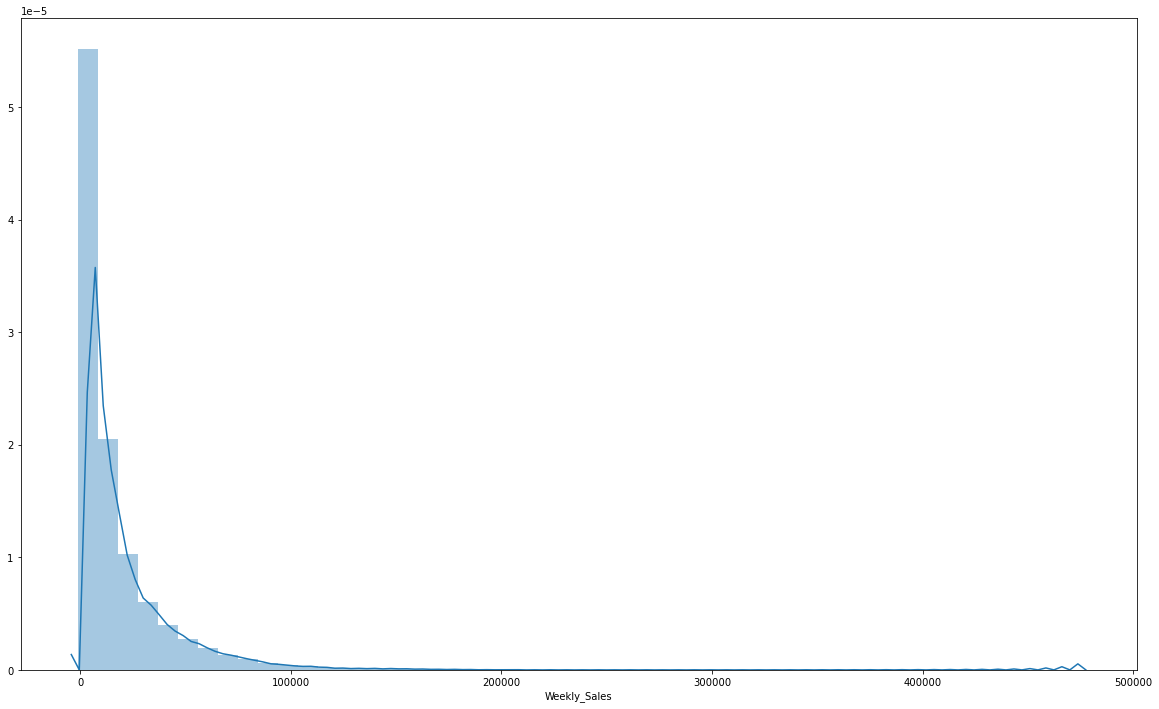

In [17]:
# 판매량의 분포
plt.figure(figsize=(20,12))
sns.distplot(train["Weekly_Sales"])

# 1. (-)값 확인가능, 이상치 처리필요
# 2. 판매량이 낮은 쪽으로 편향되어 결과값에 영향을 줄 수 있다 -> log로 처리해 분산시키기

In [18]:
train["Weekly_Sales"].sort_values()

16297      -1098.00
16295      -1098.00
16291      -1098.00
24830      -1008.96
35561       -898.00
            ...    
95377     404245.03
88428     406988.63
264390    420586.57
195088    422306.25
135665    474330.10
Name: Weekly_Sales, Length: 421561, dtype: float64

# 6. 이상치(Outlie) 및 결측치(Missing Value) 처리
- 위의 plot들과 Weekly_Sales를 정렬한 것에 따르면
1. Weekly_Sales의 -1098의 일반적인 환불로 인한 최대 마이너스 제외, 더 큰 마이너스값들은 제거 후 +1100해서 (-)값 처리
2. 동시에 60만 이상의 Weekly_Sales(4건)은 일반적으로 극히 드문 경우이므로 제거 (train set불러오면서 처리)


In [19]:
# 나머지 결측치는 -1로 치환함
train2 = train2.fillna(-1)
test2 = test2.fillna(-1)

# 7. 머신러닝 모델 설계
- Bagging방식의 RandomForest model를 통해 baseline을 잡고
- 이후 boosting model로 오차 줄이기

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 300, n_jobs = -1, random_state = 1)
rf.fit(train2,np.log(train["Weekly_Sales"]+1100))
result1 = rf.predict(test2)

from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators = 8000, num_leaves = 700)
lgb.fit(train2,np.log(train["Weekly_Sales"]+1100))
result2 = lgb.predict(test2)

# from catboost import CatBoostRegressor
# cat = CatBoostRegressor(n_estimators = 7000,task_type = "GPU", max_depth = 13)
# cat.fit(train2,np.log(train["Weekly_Sales"]+1100))
# result = cat.predict(test2)



# - 여러 시행착오 결과, 최종 앙상블은 RandomForest와 LGB 모델로 결정

Learning rate set to 0.053645
0:	learn: 1.1914986	total: 50ms	remaining: 5m 50s
1:	learn: 1.1550271	total: 88.8ms	remaining: 5m 10s
2:	learn: 1.1210126	total: 127ms	remaining: 4m 56s
3:	learn: 1.0890974	total: 168ms	remaining: 4m 54s
4:	learn: 1.0601416	total: 204ms	remaining: 4m 45s
5:	learn: 1.0327257	total: 240ms	remaining: 4m 39s
6:	learn: 1.0074807	total: 278ms	remaining: 4m 38s
7:	learn: 0.9841046	total: 318ms	remaining: 4m 37s
8:	learn: 0.9623629	total: 354ms	remaining: 4m 34s
9:	learn: 0.9422542	total: 390ms	remaining: 4m 32s
10:	learn: 0.9243100	total: 426ms	remaining: 4m 30s
11:	learn: 0.9065875	total: 462ms	remaining: 4m 28s
12:	learn: 0.8910789	total: 497ms	remaining: 4m 27s
13:	learn: 0.8756016	total: 533ms	remaining: 4m 25s
14:	learn: 0.8613752	total: 569ms	remaining: 4m 24s
15:	learn: 0.8471896	total: 604ms	remaining: 4m 23s
16:	learn: 0.8345700	total: 644ms	remaining: 4m 24s
17:	learn: 0.8223987	total: 679ms	remaining: 4m 23s
18:	learn: 0.8115977	total: 714ms	remaining:

162:	learn: 0.3933301	total: 5.9s	remaining: 4m 7s
163:	learn: 0.3923645	total: 5.93s	remaining: 4m 7s
164:	learn: 0.3911114	total: 5.97s	remaining: 4m 7s
165:	learn: 0.3903545	total: 6s	remaining: 4m 7s
166:	learn: 0.3894633	total: 6.04s	remaining: 4m 7s
167:	learn: 0.3887976	total: 6.08s	remaining: 4m 7s
168:	learn: 0.3879061	total: 6.11s	remaining: 4m 7s
169:	learn: 0.3869418	total: 6.15s	remaining: 4m 6s
170:	learn: 0.3850134	total: 6.18s	remaining: 4m 6s
171:	learn: 0.3839085	total: 6.22s	remaining: 4m 6s
172:	learn: 0.3832329	total: 6.25s	remaining: 4m 6s
173:	learn: 0.3826375	total: 6.29s	remaining: 4m 6s
174:	learn: 0.3820608	total: 6.32s	remaining: 4m 6s
175:	learn: 0.3814178	total: 6.36s	remaining: 4m 6s
176:	learn: 0.3804592	total: 6.39s	remaining: 4m 6s
177:	learn: 0.3796448	total: 6.43s	remaining: 4m 6s
178:	learn: 0.3788666	total: 6.46s	remaining: 4m 6s
179:	learn: 0.3779341	total: 6.5s	remaining: 4m 6s
180:	learn: 0.3770654	total: 6.54s	remaining: 4m 6s
181:	learn: 0.376

324:	learn: 0.2896524	total: 12s	remaining: 4m 6s
325:	learn: 0.2894073	total: 12s	remaining: 4m 6s
326:	learn: 0.2889989	total: 12.1s	remaining: 4m 6s
327:	learn: 0.2887680	total: 12.1s	remaining: 4m 6s
328:	learn: 0.2884644	total: 12.1s	remaining: 4m 6s
329:	learn: 0.2881574	total: 12.2s	remaining: 4m 5s
330:	learn: 0.2876960	total: 12.2s	remaining: 4m 5s
331:	learn: 0.2873788	total: 12.2s	remaining: 4m 5s
332:	learn: 0.2870626	total: 12.3s	remaining: 4m 5s
333:	learn: 0.2867520	total: 12.3s	remaining: 4m 5s
334:	learn: 0.2865737	total: 12.4s	remaining: 4m 5s
335:	learn: 0.2862320	total: 12.4s	remaining: 4m 5s
336:	learn: 0.2860266	total: 12.4s	remaining: 4m 5s
337:	learn: 0.2857614	total: 12.5s	remaining: 4m 5s
338:	learn: 0.2853662	total: 12.5s	remaining: 4m 5s
339:	learn: 0.2847967	total: 12.5s	remaining: 4m 5s
340:	learn: 0.2842673	total: 12.6s	remaining: 4m 5s
341:	learn: 0.2838467	total: 12.6s	remaining: 4m 5s
342:	learn: 0.2833285	total: 12.6s	remaining: 4m 5s
343:	learn: 0.28

485:	learn: 0.2424062	total: 17.9s	remaining: 3m 59s
486:	learn: 0.2422353	total: 17.9s	remaining: 3m 59s
487:	learn: 0.2420497	total: 17.9s	remaining: 3m 59s
488:	learn: 0.2418696	total: 18s	remaining: 3m 59s
489:	learn: 0.2415481	total: 18s	remaining: 3m 59s
490:	learn: 0.2413617	total: 18.1s	remaining: 3m 59s
491:	learn: 0.2411911	total: 18.1s	remaining: 3m 59s
492:	learn: 0.2410170	total: 18.1s	remaining: 3m 59s
493:	learn: 0.2406287	total: 18.2s	remaining: 3m 59s
494:	learn: 0.2404843	total: 18.2s	remaining: 3m 59s
495:	learn: 0.2403821	total: 18.2s	remaining: 3m 59s
496:	learn: 0.2401853	total: 18.3s	remaining: 3m 59s
497:	learn: 0.2400206	total: 18.3s	remaining: 3m 59s
498:	learn: 0.2398592	total: 18.3s	remaining: 3m 58s
499:	learn: 0.2396859	total: 18.4s	remaining: 3m 58s
500:	learn: 0.2395101	total: 18.4s	remaining: 3m 58s
501:	learn: 0.2393067	total: 18.5s	remaining: 3m 58s
502:	learn: 0.2388978	total: 18.5s	remaining: 3m 58s
503:	learn: 0.2386263	total: 18.5s	remaining: 3m 5

646:	learn: 0.2146831	total: 25.1s	remaining: 4m 6s
647:	learn: 0.2145749	total: 25.1s	remaining: 4m 6s
648:	learn: 0.2144684	total: 25.2s	remaining: 4m 6s
649:	learn: 0.2143077	total: 25.2s	remaining: 4m 6s
650:	learn: 0.2141960	total: 25.2s	remaining: 4m 6s
651:	learn: 0.2140919	total: 25.3s	remaining: 4m 5s
652:	learn: 0.2139846	total: 25.3s	remaining: 4m 5s
653:	learn: 0.2138585	total: 25.3s	remaining: 4m 5s
654:	learn: 0.2137859	total: 25.4s	remaining: 4m 5s
655:	learn: 0.2136651	total: 25.4s	remaining: 4m 5s
656:	learn: 0.2135426	total: 25.5s	remaining: 4m 5s
657:	learn: 0.2133988	total: 25.5s	remaining: 4m 5s
658:	learn: 0.2131815	total: 25.5s	remaining: 4m 5s
659:	learn: 0.2130253	total: 25.6s	remaining: 4m 5s
660:	learn: 0.2128790	total: 25.6s	remaining: 4m 5s
661:	learn: 0.2127705	total: 25.6s	remaining: 4m 5s
662:	learn: 0.2126758	total: 25.7s	remaining: 4m 5s
663:	learn: 0.2125482	total: 25.7s	remaining: 4m 5s
664:	learn: 0.2124439	total: 25.8s	remaining: 4m 5s
665:	learn: 

809:	learn: 0.1949573	total: 31.2s	remaining: 3m 58s
810:	learn: 0.1948956	total: 31.2s	remaining: 3m 58s
811:	learn: 0.1947177	total: 31.3s	remaining: 3m 58s
812:	learn: 0.1945785	total: 31.3s	remaining: 3m 58s
813:	learn: 0.1944194	total: 31.3s	remaining: 3m 58s
814:	learn: 0.1943251	total: 31.4s	remaining: 3m 58s
815:	learn: 0.1942794	total: 31.4s	remaining: 3m 58s
816:	learn: 0.1942211	total: 31.4s	remaining: 3m 57s
817:	learn: 0.1941144	total: 31.5s	remaining: 3m 57s
818:	learn: 0.1940322	total: 31.5s	remaining: 3m 57s
819:	learn: 0.1939770	total: 31.6s	remaining: 3m 57s
820:	learn: 0.1939153	total: 31.6s	remaining: 3m 58s
821:	learn: 0.1938100	total: 31.7s	remaining: 3m 58s
822:	learn: 0.1937429	total: 31.7s	remaining: 3m 58s
823:	learn: 0.1936382	total: 31.8s	remaining: 3m 58s
824:	learn: 0.1935479	total: 31.8s	remaining: 3m 57s
825:	learn: 0.1934652	total: 31.8s	remaining: 3m 57s
826:	learn: 0.1933797	total: 31.9s	remaining: 3m 57s
827:	learn: 0.1932853	total: 31.9s	remaining: 

966:	learn: 0.1819230	total: 37.2s	remaining: 3m 51s
967:	learn: 0.1818445	total: 37.2s	remaining: 3m 51s
968:	learn: 0.1817555	total: 37.3s	remaining: 3m 51s
969:	learn: 0.1817104	total: 37.3s	remaining: 3m 51s
970:	learn: 0.1816233	total: 37.3s	remaining: 3m 51s
971:	learn: 0.1814842	total: 37.4s	remaining: 3m 51s
972:	learn: 0.1814043	total: 37.4s	remaining: 3m 51s
973:	learn: 0.1813323	total: 37.4s	remaining: 3m 51s
974:	learn: 0.1812039	total: 37.5s	remaining: 3m 51s
975:	learn: 0.1811055	total: 37.5s	remaining: 3m 51s
976:	learn: 0.1809768	total: 37.6s	remaining: 3m 51s
977:	learn: 0.1808989	total: 37.6s	remaining: 3m 51s
978:	learn: 0.1808244	total: 37.6s	remaining: 3m 51s
979:	learn: 0.1807458	total: 37.7s	remaining: 3m 51s
980:	learn: 0.1806499	total: 37.7s	remaining: 3m 51s
981:	learn: 0.1805878	total: 37.7s	remaining: 3m 51s
982:	learn: 0.1805134	total: 37.8s	remaining: 3m 51s
983:	learn: 0.1804509	total: 37.8s	remaining: 3m 51s
984:	learn: 0.1804075	total: 37.8s	remaining: 

1123:	learn: 0.1709348	total: 43.1s	remaining: 3m 45s
1124:	learn: 0.1708689	total: 43.2s	remaining: 3m 45s
1125:	learn: 0.1707756	total: 43.2s	remaining: 3m 45s
1126:	learn: 0.1706834	total: 43.3s	remaining: 3m 45s
1127:	learn: 0.1706192	total: 43.3s	remaining: 3m 45s
1128:	learn: 0.1705389	total: 43.4s	remaining: 3m 45s
1129:	learn: 0.1704527	total: 43.4s	remaining: 3m 45s
1130:	learn: 0.1704189	total: 43.4s	remaining: 3m 45s
1131:	learn: 0.1703847	total: 43.5s	remaining: 3m 45s
1132:	learn: 0.1703089	total: 43.5s	remaining: 3m 45s
1133:	learn: 0.1702603	total: 43.6s	remaining: 3m 45s
1134:	learn: 0.1701816	total: 43.6s	remaining: 3m 45s
1135:	learn: 0.1701074	total: 43.7s	remaining: 3m 45s
1136:	learn: 0.1700407	total: 43.7s	remaining: 3m 45s
1137:	learn: 0.1700151	total: 43.7s	remaining: 3m 45s
1138:	learn: 0.1699618	total: 43.8s	remaining: 3m 45s
1139:	learn: 0.1699110	total: 43.8s	remaining: 3m 45s
1140:	learn: 0.1698435	total: 43.8s	remaining: 3m 45s
1141:	learn: 0.1697800	total

1280:	learn: 0.1619617	total: 48.9s	remaining: 3m 38s
1281:	learn: 0.1619175	total: 49s	remaining: 3m 38s
1282:	learn: 0.1618747	total: 49s	remaining: 3m 38s
1283:	learn: 0.1617948	total: 49.1s	remaining: 3m 38s
1284:	learn: 0.1617483	total: 49.1s	remaining: 3m 38s
1285:	learn: 0.1617143	total: 49.1s	remaining: 3m 38s
1286:	learn: 0.1616643	total: 49.2s	remaining: 3m 38s
1287:	learn: 0.1615668	total: 49.2s	remaining: 3m 38s
1288:	learn: 0.1615152	total: 49.2s	remaining: 3m 38s
1289:	learn: 0.1614510	total: 49.3s	remaining: 3m 38s
1290:	learn: 0.1614160	total: 49.3s	remaining: 3m 38s
1291:	learn: 0.1613460	total: 49.3s	remaining: 3m 37s
1292:	learn: 0.1613172	total: 49.4s	remaining: 3m 37s
1293:	learn: 0.1612588	total: 49.4s	remaining: 3m 37s
1294:	learn: 0.1612130	total: 49.4s	remaining: 3m 37s
1295:	learn: 0.1611722	total: 49.5s	remaining: 3m 37s
1296:	learn: 0.1611128	total: 49.5s	remaining: 3m 37s
1297:	learn: 0.1610617	total: 49.5s	remaining: 3m 37s
1298:	learn: 0.1610028	total: 49

1433:	learn: 0.1550192	total: 54.7s	remaining: 3m 32s
1434:	learn: 0.1549794	total: 54.7s	remaining: 3m 32s
1435:	learn: 0.1549373	total: 54.8s	remaining: 3m 32s
1436:	learn: 0.1548987	total: 54.8s	remaining: 3m 32s
1437:	learn: 0.1548698	total: 54.9s	remaining: 3m 32s
1438:	learn: 0.1548158	total: 54.9s	remaining: 3m 32s
1439:	learn: 0.1547691	total: 54.9s	remaining: 3m 32s
1440:	learn: 0.1547297	total: 55s	remaining: 3m 32s
1441:	learn: 0.1546603	total: 55s	remaining: 3m 31s
1442:	learn: 0.1546247	total: 55s	remaining: 3m 31s
1443:	learn: 0.1545971	total: 55.1s	remaining: 3m 31s
1444:	learn: 0.1545597	total: 55.1s	remaining: 3m 31s
1445:	learn: 0.1544973	total: 55.1s	remaining: 3m 31s
1446:	learn: 0.1544718	total: 55.2s	remaining: 3m 31s
1447:	learn: 0.1544323	total: 55.2s	remaining: 3m 31s
1448:	learn: 0.1543980	total: 55.2s	remaining: 3m 31s
1449:	learn: 0.1543774	total: 55.3s	remaining: 3m 31s
1450:	learn: 0.1543490	total: 55.3s	remaining: 3m 31s
1451:	learn: 0.1543267	total: 55.4

1586:	learn: 0.1488556	total: 1m	remaining: 3m 25s
1587:	learn: 0.1488226	total: 1m	remaining: 3m 25s
1588:	learn: 0.1487855	total: 1m	remaining: 3m 25s
1589:	learn: 0.1487536	total: 1m	remaining: 3m 25s
1590:	learn: 0.1487059	total: 1m	remaining: 3m 25s
1591:	learn: 0.1486788	total: 1m	remaining: 3m 25s
1592:	learn: 0.1486588	total: 1m	remaining: 3m 25s
1593:	learn: 0.1486321	total: 1m	remaining: 3m 25s
1594:	learn: 0.1485897	total: 1m	remaining: 3m 25s
1595:	learn: 0.1485542	total: 1m	remaining: 3m 25s
1596:	learn: 0.1485183	total: 1m	remaining: 3m 25s
1597:	learn: 0.1484811	total: 1m	remaining: 3m 25s
1598:	learn: 0.1484326	total: 1m	remaining: 3m 25s
1599:	learn: 0.1483678	total: 1m	remaining: 3m 25s
1600:	learn: 0.1483531	total: 1m	remaining: 3m 25s
1601:	learn: 0.1483304	total: 1m	remaining: 3m 25s
1602:	learn: 0.1482768	total: 1m	remaining: 3m 25s
1603:	learn: 0.1482493	total: 1m	remaining: 3m 25s
1604:	learn: 0.1482132	total: 1m 1s	remaining: 3m 25s
1605:	learn: 0.1481932	total

1742:	learn: 0.1436932	total: 1m 6s	remaining: 3m 20s
1743:	learn: 0.1436692	total: 1m 6s	remaining: 3m 20s
1744:	learn: 0.1436395	total: 1m 6s	remaining: 3m 19s
1745:	learn: 0.1436161	total: 1m 6s	remaining: 3m 19s
1746:	learn: 0.1435824	total: 1m 6s	remaining: 3m 19s
1747:	learn: 0.1435484	total: 1m 6s	remaining: 3m 19s
1748:	learn: 0.1435052	total: 1m 6s	remaining: 3m 19s
1749:	learn: 0.1434795	total: 1m 6s	remaining: 3m 19s
1750:	learn: 0.1434474	total: 1m 6s	remaining: 3m 19s
1751:	learn: 0.1434011	total: 1m 6s	remaining: 3m 19s
1752:	learn: 0.1433808	total: 1m 6s	remaining: 3m 19s
1753:	learn: 0.1433492	total: 1m 6s	remaining: 3m 19s
1754:	learn: 0.1433204	total: 1m 6s	remaining: 3m 19s
1755:	learn: 0.1432897	total: 1m 6s	remaining: 3m 19s
1756:	learn: 0.1432692	total: 1m 6s	remaining: 3m 19s
1757:	learn: 0.1432286	total: 1m 6s	remaining: 3m 19s
1758:	learn: 0.1432060	total: 1m 6s	remaining: 3m 19s
1759:	learn: 0.1431530	total: 1m 6s	remaining: 3m 19s
1760:	learn: 0.1431211	total

1898:	learn: 0.1391289	total: 1m 11s	remaining: 3m 13s
1899:	learn: 0.1391026	total: 1m 11s	remaining: 3m 13s
1900:	learn: 0.1390838	total: 1m 11s	remaining: 3m 13s
1901:	learn: 0.1390259	total: 1m 12s	remaining: 3m 13s
1902:	learn: 0.1390079	total: 1m 12s	remaining: 3m 13s
1903:	learn: 0.1389614	total: 1m 12s	remaining: 3m 12s
1904:	learn: 0.1389272	total: 1m 12s	remaining: 3m 12s
1905:	learn: 0.1389084	total: 1m 12s	remaining: 3m 12s
1906:	learn: 0.1388691	total: 1m 12s	remaining: 3m 12s
1907:	learn: 0.1388441	total: 1m 12s	remaining: 3m 12s
1908:	learn: 0.1388244	total: 1m 12s	remaining: 3m 12s
1909:	learn: 0.1387942	total: 1m 12s	remaining: 3m 12s
1910:	learn: 0.1387779	total: 1m 12s	remaining: 3m 12s
1911:	learn: 0.1387564	total: 1m 12s	remaining: 3m 12s
1912:	learn: 0.1387266	total: 1m 12s	remaining: 3m 12s
1913:	learn: 0.1387091	total: 1m 12s	remaining: 3m 12s
1914:	learn: 0.1386663	total: 1m 12s	remaining: 3m 12s
1915:	learn: 0.1386346	total: 1m 12s	remaining: 3m 12s
1916:	lear

2054:	learn: 0.1352101	total: 1m 17s	remaining: 3m 7s
2055:	learn: 0.1351934	total: 1m 18s	remaining: 3m 7s
2056:	learn: 0.1351558	total: 1m 18s	remaining: 3m 7s
2057:	learn: 0.1351354	total: 1m 18s	remaining: 3m 7s
2058:	learn: 0.1351108	total: 1m 18s	remaining: 3m 7s
2059:	learn: 0.1350840	total: 1m 18s	remaining: 3m 7s
2060:	learn: 0.1350649	total: 1m 18s	remaining: 3m 7s
2061:	learn: 0.1350367	total: 1m 18s	remaining: 3m 7s
2062:	learn: 0.1350092	total: 1m 18s	remaining: 3m 7s
2063:	learn: 0.1349938	total: 1m 18s	remaining: 3m 7s
2064:	learn: 0.1349445	total: 1m 18s	remaining: 3m 7s
2065:	learn: 0.1349230	total: 1m 18s	remaining: 3m 7s
2066:	learn: 0.1348815	total: 1m 18s	remaining: 3m 7s
2067:	learn: 0.1348517	total: 1m 18s	remaining: 3m 7s
2068:	learn: 0.1348376	total: 1m 18s	remaining: 3m 7s
2069:	learn: 0.1348187	total: 1m 18s	remaining: 3m 7s
2070:	learn: 0.1347972	total: 1m 18s	remaining: 3m 6s
2071:	learn: 0.1347795	total: 1m 18s	remaining: 3m 6s
2072:	learn: 0.1347572	total

2210:	learn: 0.1315899	total: 1m 24s	remaining: 3m 2s
2211:	learn: 0.1315560	total: 1m 24s	remaining: 3m 2s
2212:	learn: 0.1315231	total: 1m 24s	remaining: 3m 2s
2213:	learn: 0.1315004	total: 1m 24s	remaining: 3m 2s
2214:	learn: 0.1314759	total: 1m 24s	remaining: 3m 2s
2215:	learn: 0.1314566	total: 1m 24s	remaining: 3m 2s
2216:	learn: 0.1314328	total: 1m 24s	remaining: 3m 2s
2217:	learn: 0.1314203	total: 1m 24s	remaining: 3m 2s
2218:	learn: 0.1314061	total: 1m 24s	remaining: 3m 2s
2219:	learn: 0.1313896	total: 1m 24s	remaining: 3m 2s
2220:	learn: 0.1313605	total: 1m 24s	remaining: 3m 2s
2221:	learn: 0.1313413	total: 1m 24s	remaining: 3m 1s
2222:	learn: 0.1313162	total: 1m 24s	remaining: 3m 1s
2223:	learn: 0.1312959	total: 1m 24s	remaining: 3m 1s
2224:	learn: 0.1312725	total: 1m 24s	remaining: 3m 1s
2225:	learn: 0.1312450	total: 1m 24s	remaining: 3m 1s
2226:	learn: 0.1312277	total: 1m 24s	remaining: 3m 1s
2227:	learn: 0.1312013	total: 1m 24s	remaining: 3m 1s
2228:	learn: 0.1311879	total

2365:	learn: 0.1284359	total: 1m 30s	remaining: 2m 57s
2366:	learn: 0.1284269	total: 1m 30s	remaining: 2m 57s
2367:	learn: 0.1284114	total: 1m 30s	remaining: 2m 57s
2368:	learn: 0.1283878	total: 1m 30s	remaining: 2m 57s
2369:	learn: 0.1283662	total: 1m 30s	remaining: 2m 57s
2370:	learn: 0.1283407	total: 1m 30s	remaining: 2m 57s
2371:	learn: 0.1283048	total: 1m 30s	remaining: 2m 57s
2372:	learn: 0.1282870	total: 1m 30s	remaining: 2m 57s
2373:	learn: 0.1282651	total: 1m 30s	remaining: 2m 56s
2374:	learn: 0.1282362	total: 1m 30s	remaining: 2m 56s
2375:	learn: 0.1282230	total: 1m 30s	remaining: 2m 56s
2376:	learn: 0.1281986	total: 1m 30s	remaining: 2m 56s
2377:	learn: 0.1281779	total: 1m 30s	remaining: 2m 56s
2378:	learn: 0.1281576	total: 1m 31s	remaining: 2m 56s
2379:	learn: 0.1281379	total: 1m 31s	remaining: 2m 56s
2380:	learn: 0.1281206	total: 1m 31s	remaining: 2m 56s
2381:	learn: 0.1280968	total: 1m 31s	remaining: 2m 56s
2382:	learn: 0.1280678	total: 1m 31s	remaining: 2m 56s
2383:	lear

2514:	learn: 0.1256202	total: 1m 35s	remaining: 2m 51s
2515:	learn: 0.1256048	total: 1m 35s	remaining: 2m 51s
2516:	learn: 0.1255711	total: 1m 35s	remaining: 2m 50s
2517:	learn: 0.1255603	total: 1m 36s	remaining: 2m 50s
2518:	learn: 0.1255406	total: 1m 36s	remaining: 2m 50s
2519:	learn: 0.1255236	total: 1m 36s	remaining: 2m 50s
2520:	learn: 0.1255076	total: 1m 36s	remaining: 2m 50s
2521:	learn: 0.1254846	total: 1m 36s	remaining: 2m 50s
2522:	learn: 0.1254682	total: 1m 36s	remaining: 2m 50s
2523:	learn: 0.1254545	total: 1m 36s	remaining: 2m 50s
2524:	learn: 0.1254209	total: 1m 36s	remaining: 2m 50s
2525:	learn: 0.1254016	total: 1m 36s	remaining: 2m 50s
2526:	learn: 0.1253855	total: 1m 36s	remaining: 2m 50s
2527:	learn: 0.1253742	total: 1m 36s	remaining: 2m 50s
2528:	learn: 0.1253538	total: 1m 36s	remaining: 2m 50s
2529:	learn: 0.1253333	total: 1m 36s	remaining: 2m 50s
2530:	learn: 0.1253119	total: 1m 36s	remaining: 2m 50s
2531:	learn: 0.1252966	total: 1m 36s	remaining: 2m 50s
2532:	lear

2664:	learn: 0.1230876	total: 1m 41s	remaining: 2m 45s
2665:	learn: 0.1230793	total: 1m 41s	remaining: 2m 45s
2666:	learn: 0.1230616	total: 1m 41s	remaining: 2m 45s
2667:	learn: 0.1230510	total: 1m 41s	remaining: 2m 45s
2668:	learn: 0.1230361	total: 1m 41s	remaining: 2m 45s
2669:	learn: 0.1230249	total: 1m 41s	remaining: 2m 44s
2670:	learn: 0.1229944	total: 1m 41s	remaining: 2m 44s
2671:	learn: 0.1229762	total: 1m 41s	remaining: 2m 44s
2672:	learn: 0.1229645	total: 1m 41s	remaining: 2m 44s
2673:	learn: 0.1229526	total: 1m 41s	remaining: 2m 44s
2674:	learn: 0.1229421	total: 1m 41s	remaining: 2m 44s
2675:	learn: 0.1229103	total: 1m 41s	remaining: 2m 44s
2676:	learn: 0.1229017	total: 1m 41s	remaining: 2m 44s
2677:	learn: 0.1228901	total: 1m 42s	remaining: 2m 44s
2678:	learn: 0.1228777	total: 1m 42s	remaining: 2m 44s
2679:	learn: 0.1228610	total: 1m 42s	remaining: 2m 44s
2680:	learn: 0.1228485	total: 1m 42s	remaining: 2m 44s
2681:	learn: 0.1228401	total: 1m 42s	remaining: 2m 44s
2682:	lear

2814:	learn: 0.1208266	total: 1m 46s	remaining: 2m 39s
2815:	learn: 0.1208068	total: 1m 47s	remaining: 2m 38s
2816:	learn: 0.1207883	total: 1m 47s	remaining: 2m 38s
2817:	learn: 0.1207745	total: 1m 47s	remaining: 2m 38s
2818:	learn: 0.1207605	total: 1m 47s	remaining: 2m 38s
2819:	learn: 0.1207497	total: 1m 47s	remaining: 2m 38s
2820:	learn: 0.1207345	total: 1m 47s	remaining: 2m 38s
2821:	learn: 0.1207270	total: 1m 47s	remaining: 2m 38s
2822:	learn: 0.1207170	total: 1m 47s	remaining: 2m 38s
2823:	learn: 0.1207032	total: 1m 47s	remaining: 2m 38s
2824:	learn: 0.1206885	total: 1m 47s	remaining: 2m 38s
2825:	learn: 0.1206800	total: 1m 47s	remaining: 2m 38s
2826:	learn: 0.1206677	total: 1m 47s	remaining: 2m 38s
2827:	learn: 0.1206530	total: 1m 47s	remaining: 2m 38s
2828:	learn: 0.1206342	total: 1m 47s	remaining: 2m 38s
2829:	learn: 0.1206226	total: 1m 47s	remaining: 2m 38s
2830:	learn: 0.1206083	total: 1m 47s	remaining: 2m 38s
2831:	learn: 0.1205953	total: 1m 47s	remaining: 2m 38s
2832:	lear

2965:	learn: 0.1187646	total: 1m 52s	remaining: 2m 33s
2966:	learn: 0.1187569	total: 1m 52s	remaining: 2m 33s
2967:	learn: 0.1187440	total: 1m 52s	remaining: 2m 33s
2968:	learn: 0.1187349	total: 1m 52s	remaining: 2m 33s
2969:	learn: 0.1187256	total: 1m 52s	remaining: 2m 33s
2970:	learn: 0.1187034	total: 1m 52s	remaining: 2m 32s
2971:	learn: 0.1186862	total: 1m 52s	remaining: 2m 32s
2972:	learn: 0.1186714	total: 1m 52s	remaining: 2m 32s
2973:	learn: 0.1186587	total: 1m 52s	remaining: 2m 32s
2974:	learn: 0.1186445	total: 1m 52s	remaining: 2m 32s
2975:	learn: 0.1186334	total: 1m 52s	remaining: 2m 32s
2976:	learn: 0.1186240	total: 1m 53s	remaining: 2m 32s
2977:	learn: 0.1186078	total: 1m 53s	remaining: 2m 32s
2978:	learn: 0.1185882	total: 1m 53s	remaining: 2m 32s
2979:	learn: 0.1185784	total: 1m 53s	remaining: 2m 32s
2980:	learn: 0.1185634	total: 1m 53s	remaining: 2m 32s
2981:	learn: 0.1185556	total: 1m 53s	remaining: 2m 32s
2982:	learn: 0.1185390	total: 1m 53s	remaining: 2m 32s
2983:	lear

3119:	learn: 0.1166705	total: 1m 58s	remaining: 2m 27s
3120:	learn: 0.1166573	total: 1m 58s	remaining: 2m 27s
3121:	learn: 0.1166343	total: 1m 58s	remaining: 2m 27s
3122:	learn: 0.1166222	total: 1m 58s	remaining: 2m 27s
3123:	learn: 0.1166093	total: 1m 58s	remaining: 2m 26s
3124:	learn: 0.1165984	total: 1m 58s	remaining: 2m 26s
3125:	learn: 0.1165888	total: 1m 58s	remaining: 2m 26s
3126:	learn: 0.1165735	total: 1m 58s	remaining: 2m 26s
3127:	learn: 0.1165642	total: 1m 58s	remaining: 2m 26s
3128:	learn: 0.1165555	total: 1m 58s	remaining: 2m 26s
3129:	learn: 0.1165418	total: 1m 58s	remaining: 2m 26s
3130:	learn: 0.1165261	total: 1m 58s	remaining: 2m 26s
3131:	learn: 0.1165125	total: 1m 58s	remaining: 2m 26s
3132:	learn: 0.1164994	total: 1m 58s	remaining: 2m 26s
3133:	learn: 0.1164897	total: 1m 58s	remaining: 2m 26s
3134:	learn: 0.1164722	total: 1m 58s	remaining: 2m 26s
3135:	learn: 0.1164608	total: 1m 58s	remaining: 2m 26s
3136:	learn: 0.1164539	total: 1m 59s	remaining: 2m 26s
3137:	lear

3275:	learn: 0.1146596	total: 2m 4s	remaining: 2m 21s
3276:	learn: 0.1146450	total: 2m 4s	remaining: 2m 21s
3277:	learn: 0.1146410	total: 2m 4s	remaining: 2m 21s
3278:	learn: 0.1146256	total: 2m 4s	remaining: 2m 21s
3279:	learn: 0.1146117	total: 2m 4s	remaining: 2m 21s
3280:	learn: 0.1145913	total: 2m 4s	remaining: 2m 21s
3281:	learn: 0.1145795	total: 2m 4s	remaining: 2m 21s
3282:	learn: 0.1145692	total: 2m 4s	remaining: 2m 21s
3283:	learn: 0.1145527	total: 2m 4s	remaining: 2m 20s
3284:	learn: 0.1145334	total: 2m 4s	remaining: 2m 20s
3285:	learn: 0.1145221	total: 2m 4s	remaining: 2m 20s
3286:	learn: 0.1145093	total: 2m 4s	remaining: 2m 20s
3287:	learn: 0.1144945	total: 2m 4s	remaining: 2m 20s
3288:	learn: 0.1144861	total: 2m 4s	remaining: 2m 20s
3289:	learn: 0.1144786	total: 2m 4s	remaining: 2m 20s
3290:	learn: 0.1144697	total: 2m 4s	remaining: 2m 20s
3291:	learn: 0.1144608	total: 2m 4s	remaining: 2m 20s
3292:	learn: 0.1144477	total: 2m 4s	remaining: 2m 20s
3293:	learn: 0.1144334	total

3428:	learn: 0.1128215	total: 2m 10s	remaining: 2m 15s
3429:	learn: 0.1128129	total: 2m 10s	remaining: 2m 15s
3430:	learn: 0.1128020	total: 2m 10s	remaining: 2m 15s
3431:	learn: 0.1127928	total: 2m 10s	remaining: 2m 15s
3432:	learn: 0.1127817	total: 2m 10s	remaining: 2m 15s
3433:	learn: 0.1127698	total: 2m 10s	remaining: 2m 15s
3434:	learn: 0.1127562	total: 2m 10s	remaining: 2m 15s
3435:	learn: 0.1127487	total: 2m 10s	remaining: 2m 15s
3436:	learn: 0.1127326	total: 2m 10s	remaining: 2m 15s
3437:	learn: 0.1127191	total: 2m 10s	remaining: 2m 15s
3438:	learn: 0.1127080	total: 2m 10s	remaining: 2m 15s
3439:	learn: 0.1126952	total: 2m 10s	remaining: 2m 14s
3440:	learn: 0.1126844	total: 2m 10s	remaining: 2m 14s
3441:	learn: 0.1126722	total: 2m 10s	remaining: 2m 14s
3442:	learn: 0.1126641	total: 2m 10s	remaining: 2m 14s
3443:	learn: 0.1126524	total: 2m 10s	remaining: 2m 14s
3444:	learn: 0.1126394	total: 2m 10s	remaining: 2m 14s
3445:	learn: 0.1126321	total: 2m 10s	remaining: 2m 14s
3446:	lear

3578:	learn: 0.1112113	total: 2m 15s	remaining: 2m 9s
3579:	learn: 0.1112053	total: 2m 15s	remaining: 2m 9s
3580:	learn: 0.1111908	total: 2m 15s	remaining: 2m 9s
3581:	learn: 0.1111770	total: 2m 15s	remaining: 2m 9s
3582:	learn: 0.1111681	total: 2m 15s	remaining: 2m 9s
3583:	learn: 0.1111571	total: 2m 15s	remaining: 2m 9s
3584:	learn: 0.1111441	total: 2m 15s	remaining: 2m 9s
3585:	learn: 0.1111365	total: 2m 15s	remaining: 2m 9s
3586:	learn: 0.1111289	total: 2m 15s	remaining: 2m 9s
3587:	learn: 0.1111188	total: 2m 15s	remaining: 2m 9s
3588:	learn: 0.1111089	total: 2m 15s	remaining: 2m 9s
3589:	learn: 0.1110957	total: 2m 15s	remaining: 2m 9s
3590:	learn: 0.1110897	total: 2m 15s	remaining: 2m 9s
3591:	learn: 0.1110769	total: 2m 15s	remaining: 2m 8s
3592:	learn: 0.1110654	total: 2m 15s	remaining: 2m 8s
3593:	learn: 0.1110609	total: 2m 16s	remaining: 2m 8s
3594:	learn: 0.1110543	total: 2m 16s	remaining: 2m 8s
3595:	learn: 0.1110460	total: 2m 16s	remaining: 2m 8s
3596:	learn: 0.1110347	total

3733:	learn: 0.1096736	total: 2m 21s	remaining: 2m 4s
3734:	learn: 0.1096680	total: 2m 21s	remaining: 2m 4s
3735:	learn: 0.1096586	total: 2m 22s	remaining: 2m 4s
3736:	learn: 0.1096510	total: 2m 22s	remaining: 2m 4s
3737:	learn: 0.1096419	total: 2m 22s	remaining: 2m 3s
3738:	learn: 0.1096325	total: 2m 22s	remaining: 2m 3s
3739:	learn: 0.1096251	total: 2m 22s	remaining: 2m 3s
3740:	learn: 0.1096154	total: 2m 22s	remaining: 2m 3s
3741:	learn: 0.1096054	total: 2m 22s	remaining: 2m 3s
3742:	learn: 0.1095987	total: 2m 22s	remaining: 2m 3s
3743:	learn: 0.1095861	total: 2m 22s	remaining: 2m 3s
3744:	learn: 0.1095782	total: 2m 22s	remaining: 2m 3s
3745:	learn: 0.1095672	total: 2m 22s	remaining: 2m 3s
3746:	learn: 0.1095547	total: 2m 22s	remaining: 2m 3s
3747:	learn: 0.1095418	total: 2m 22s	remaining: 2m 3s
3748:	learn: 0.1095282	total: 2m 22s	remaining: 2m 3s
3749:	learn: 0.1095178	total: 2m 22s	remaining: 2m 3s
3750:	learn: 0.1095096	total: 2m 22s	remaining: 2m 3s
3751:	learn: 0.1095028	total

3889:	learn: 0.1081716	total: 2m 28s	remaining: 1m 58s
3890:	learn: 0.1081661	total: 2m 28s	remaining: 1m 58s
3891:	learn: 0.1081545	total: 2m 28s	remaining: 1m 58s
3892:	learn: 0.1081487	total: 2m 28s	remaining: 1m 58s
3893:	learn: 0.1081345	total: 2m 28s	remaining: 1m 58s
3894:	learn: 0.1081266	total: 2m 28s	remaining: 1m 58s
3895:	learn: 0.1081156	total: 2m 28s	remaining: 1m 58s
3896:	learn: 0.1081030	total: 2m 28s	remaining: 1m 58s
3897:	learn: 0.1080876	total: 2m 28s	remaining: 1m 58s
3898:	learn: 0.1080722	total: 2m 28s	remaining: 1m 58s
3899:	learn: 0.1080646	total: 2m 28s	remaining: 1m 58s
3900:	learn: 0.1080560	total: 2m 28s	remaining: 1m 57s
3901:	learn: 0.1080494	total: 2m 28s	remaining: 1m 57s
3902:	learn: 0.1080394	total: 2m 28s	remaining: 1m 57s
3903:	learn: 0.1080353	total: 2m 28s	remaining: 1m 57s
3904:	learn: 0.1080261	total: 2m 28s	remaining: 1m 57s
3905:	learn: 0.1080144	total: 2m 28s	remaining: 1m 57s
3906:	learn: 0.1080087	total: 2m 28s	remaining: 1m 57s
3907:	lear

4042:	learn: 0.1067809	total: 2m 34s	remaining: 1m 52s
4043:	learn: 0.1067707	total: 2m 34s	remaining: 1m 52s
4044:	learn: 0.1067623	total: 2m 34s	remaining: 1m 52s
4045:	learn: 0.1067518	total: 2m 34s	remaining: 1m 52s
4046:	learn: 0.1067408	total: 2m 34s	remaining: 1m 52s
4047:	learn: 0.1067306	total: 2m 34s	remaining: 1m 52s
4048:	learn: 0.1067219	total: 2m 34s	remaining: 1m 52s
4049:	learn: 0.1067148	total: 2m 34s	remaining: 1m 52s
4050:	learn: 0.1067077	total: 2m 34s	remaining: 1m 52s
4051:	learn: 0.1066973	total: 2m 34s	remaining: 1m 52s
4052:	learn: 0.1066917	total: 2m 34s	remaining: 1m 52s
4053:	learn: 0.1066812	total: 2m 34s	remaining: 1m 52s
4054:	learn: 0.1066700	total: 2m 34s	remaining: 1m 52s
4055:	learn: 0.1066566	total: 2m 34s	remaining: 1m 52s
4056:	learn: 0.1066506	total: 2m 34s	remaining: 1m 52s
4057:	learn: 0.1066390	total: 2m 34s	remaining: 1m 52s
4058:	learn: 0.1066294	total: 2m 34s	remaining: 1m 52s
4059:	learn: 0.1066179	total: 2m 34s	remaining: 1m 52s
4060:	lear

4192:	learn: 0.1055068	total: 2m 40s	remaining: 1m 47s
4193:	learn: 0.1054990	total: 2m 40s	remaining: 1m 47s
4194:	learn: 0.1054895	total: 2m 40s	remaining: 1m 47s
4195:	learn: 0.1054828	total: 2m 40s	remaining: 1m 47s
4196:	learn: 0.1054766	total: 2m 40s	remaining: 1m 47s
4197:	learn: 0.1054708	total: 2m 40s	remaining: 1m 47s
4198:	learn: 0.1054634	total: 2m 40s	remaining: 1m 46s
4199:	learn: 0.1054571	total: 2m 40s	remaining: 1m 46s
4200:	learn: 0.1054505	total: 2m 40s	remaining: 1m 46s
4201:	learn: 0.1054428	total: 2m 40s	remaining: 1m 46s
4202:	learn: 0.1054300	total: 2m 40s	remaining: 1m 46s
4203:	learn: 0.1054214	total: 2m 40s	remaining: 1m 46s
4204:	learn: 0.1054148	total: 2m 40s	remaining: 1m 46s
4205:	learn: 0.1054079	total: 2m 40s	remaining: 1m 46s
4206:	learn: 0.1054007	total: 2m 40s	remaining: 1m 46s
4207:	learn: 0.1053925	total: 2m 40s	remaining: 1m 46s
4208:	learn: 0.1053843	total: 2m 40s	remaining: 1m 46s
4209:	learn: 0.1053738	total: 2m 40s	remaining: 1m 46s
4210:	lear

4342:	learn: 0.1043306	total: 2m 45s	remaining: 1m 41s
4343:	learn: 0.1043239	total: 2m 45s	remaining: 1m 41s
4344:	learn: 0.1043134	total: 2m 45s	remaining: 1m 41s
4345:	learn: 0.1043052	total: 2m 45s	remaining: 1m 41s
4346:	learn: 0.1042987	total: 2m 45s	remaining: 1m 41s
4347:	learn: 0.1042926	total: 2m 45s	remaining: 1m 41s
4348:	learn: 0.1042865	total: 2m 46s	remaining: 1m 41s
4349:	learn: 0.1042779	total: 2m 46s	remaining: 1m 41s
4350:	learn: 0.1042710	total: 2m 46s	remaining: 1m 41s
4351:	learn: 0.1042631	total: 2m 46s	remaining: 1m 41s
4352:	learn: 0.1042504	total: 2m 46s	remaining: 1m 41s
4353:	learn: 0.1042456	total: 2m 46s	remaining: 1m 41s
4354:	learn: 0.1042413	total: 2m 46s	remaining: 1m 40s
4355:	learn: 0.1042311	total: 2m 46s	remaining: 1m 40s
4356:	learn: 0.1042209	total: 2m 46s	remaining: 1m 40s
4357:	learn: 0.1042118	total: 2m 46s	remaining: 1m 40s
4358:	learn: 0.1042047	total: 2m 46s	remaining: 1m 40s
4359:	learn: 0.1041986	total: 2m 46s	remaining: 1m 40s
4360:	lear

4491:	learn: 0.1031928	total: 2m 51s	remaining: 1m 35s
4492:	learn: 0.1031850	total: 2m 51s	remaining: 1m 35s
4493:	learn: 0.1031776	total: 2m 51s	remaining: 1m 35s
4494:	learn: 0.1031673	total: 2m 51s	remaining: 1m 35s
4495:	learn: 0.1031571	total: 2m 51s	remaining: 1m 35s
4496:	learn: 0.1031527	total: 2m 51s	remaining: 1m 35s
4497:	learn: 0.1031453	total: 2m 51s	remaining: 1m 35s
4498:	learn: 0.1031356	total: 2m 51s	remaining: 1m 35s
4499:	learn: 0.1031258	total: 2m 51s	remaining: 1m 35s
4500:	learn: 0.1031180	total: 2m 51s	remaining: 1m 35s
4501:	learn: 0.1031153	total: 2m 51s	remaining: 1m 35s
4502:	learn: 0.1031082	total: 2m 51s	remaining: 1m 35s
4503:	learn: 0.1031010	total: 2m 51s	remaining: 1m 35s
4504:	learn: 0.1030935	total: 2m 51s	remaining: 1m 35s
4505:	learn: 0.1030870	total: 2m 51s	remaining: 1m 35s
4506:	learn: 0.1030801	total: 2m 51s	remaining: 1m 34s
4507:	learn: 0.1030736	total: 2m 51s	remaining: 1m 34s
4508:	learn: 0.1030685	total: 2m 51s	remaining: 1m 34s
4509:	lear

4641:	learn: 0.1020670	total: 2m 56s	remaining: 1m 29s
4642:	learn: 0.1020639	total: 2m 56s	remaining: 1m 29s
4643:	learn: 0.1020549	total: 2m 57s	remaining: 1m 29s
4644:	learn: 0.1020483	total: 2m 57s	remaining: 1m 29s
4645:	learn: 0.1020430	total: 2m 57s	remaining: 1m 29s
4646:	learn: 0.1020374	total: 2m 57s	remaining: 1m 29s
4647:	learn: 0.1020326	total: 2m 57s	remaining: 1m 29s
4648:	learn: 0.1020270	total: 2m 57s	remaining: 1m 29s
4649:	learn: 0.1020222	total: 2m 57s	remaining: 1m 29s
4650:	learn: 0.1020100	total: 2m 57s	remaining: 1m 29s
4651:	learn: 0.1020049	total: 2m 57s	remaining: 1m 29s
4652:	learn: 0.1019992	total: 2m 57s	remaining: 1m 29s
4653:	learn: 0.1019929	total: 2m 57s	remaining: 1m 29s
4654:	learn: 0.1019862	total: 2m 57s	remaining: 1m 29s
4655:	learn: 0.1019816	total: 2m 57s	remaining: 1m 29s
4656:	learn: 0.1019727	total: 2m 57s	remaining: 1m 29s
4657:	learn: 0.1019672	total: 2m 57s	remaining: 1m 29s
4658:	learn: 0.1019621	total: 2m 57s	remaining: 1m 29s
4659:	lear

4797:	learn: 0.1009634	total: 3m 2s	remaining: 1m 23s
4798:	learn: 0.1009581	total: 3m 2s	remaining: 1m 23s
4799:	learn: 0.1009530	total: 3m 2s	remaining: 1m 23s
4800:	learn: 0.1009461	total: 3m 2s	remaining: 1m 23s
4801:	learn: 0.1009371	total: 3m 2s	remaining: 1m 23s
4802:	learn: 0.1009312	total: 3m 2s	remaining: 1m 23s
4803:	learn: 0.1009204	total: 3m 2s	remaining: 1m 23s
4804:	learn: 0.1009129	total: 3m 2s	remaining: 1m 23s
4805:	learn: 0.1009068	total: 3m 2s	remaining: 1m 23s
4806:	learn: 0.1009020	total: 3m 2s	remaining: 1m 23s
4807:	learn: 0.1008945	total: 3m 2s	remaining: 1m 23s
4808:	learn: 0.1008878	total: 3m 3s	remaining: 1m 23s
4809:	learn: 0.1008809	total: 3m 3s	remaining: 1m 23s
4810:	learn: 0.1008712	total: 3m 3s	remaining: 1m 23s
4811:	learn: 0.1008615	total: 3m 3s	remaining: 1m 23s
4812:	learn: 0.1008555	total: 3m 3s	remaining: 1m 23s
4813:	learn: 0.1008496	total: 3m 3s	remaining: 1m 23s
4814:	learn: 0.1008397	total: 3m 3s	remaining: 1m 23s
4815:	learn: 0.1008339	total

4949:	learn: 0.0999092	total: 3m 8s	remaining: 1m 18s
4950:	learn: 0.0999034	total: 3m 8s	remaining: 1m 18s
4951:	learn: 0.0998984	total: 3m 8s	remaining: 1m 18s
4952:	learn: 0.0998932	total: 3m 8s	remaining: 1m 17s
4953:	learn: 0.0998873	total: 3m 8s	remaining: 1m 17s
4954:	learn: 0.0998820	total: 3m 8s	remaining: 1m 17s
4955:	learn: 0.0998762	total: 3m 8s	remaining: 1m 17s
4956:	learn: 0.0998711	total: 3m 8s	remaining: 1m 17s
4957:	learn: 0.0998633	total: 3m 8s	remaining: 1m 17s
4958:	learn: 0.0998569	total: 3m 8s	remaining: 1m 17s
4959:	learn: 0.0998513	total: 3m 8s	remaining: 1m 17s
4960:	learn: 0.0998430	total: 3m 9s	remaining: 1m 17s
4961:	learn: 0.0998371	total: 3m 9s	remaining: 1m 17s
4962:	learn: 0.0998276	total: 3m 9s	remaining: 1m 17s
4963:	learn: 0.0998213	total: 3m 9s	remaining: 1m 17s
4964:	learn: 0.0998126	total: 3m 9s	remaining: 1m 17s
4965:	learn: 0.0998070	total: 3m 9s	remaining: 1m 17s
4966:	learn: 0.0998018	total: 3m 9s	remaining: 1m 17s
4967:	learn: 0.0997951	total

5099:	learn: 0.0989562	total: 3m 14s	remaining: 1m 12s
5100:	learn: 0.0989491	total: 3m 14s	remaining: 1m 12s
5101:	learn: 0.0989461	total: 3m 14s	remaining: 1m 12s
5102:	learn: 0.0989395	total: 3m 14s	remaining: 1m 12s
5103:	learn: 0.0989317	total: 3m 14s	remaining: 1m 12s
5104:	learn: 0.0989270	total: 3m 14s	remaining: 1m 12s
5105:	learn: 0.0989232	total: 3m 14s	remaining: 1m 12s
5106:	learn: 0.0989166	total: 3m 14s	remaining: 1m 12s
5107:	learn: 0.0989121	total: 3m 14s	remaining: 1m 11s
5108:	learn: 0.0989080	total: 3m 14s	remaining: 1m 11s
5109:	learn: 0.0989033	total: 3m 14s	remaining: 1m 11s
5110:	learn: 0.0988974	total: 3m 14s	remaining: 1m 11s
5111:	learn: 0.0988902	total: 3m 14s	remaining: 1m 11s
5112:	learn: 0.0988847	total: 3m 14s	remaining: 1m 11s
5113:	learn: 0.0988779	total: 3m 14s	remaining: 1m 11s
5114:	learn: 0.0988724	total: 3m 14s	remaining: 1m 11s
5115:	learn: 0.0988651	total: 3m 14s	remaining: 1m 11s
5116:	learn: 0.0988552	total: 3m 14s	remaining: 1m 11s
5117:	lear

5250:	learn: 0.0980062	total: 3m 20s	remaining: 1m 6s
5251:	learn: 0.0980012	total: 3m 20s	remaining: 1m 6s
5252:	learn: 0.0979924	total: 3m 20s	remaining: 1m 6s
5253:	learn: 0.0979809	total: 3m 20s	remaining: 1m 6s
5254:	learn: 0.0979708	total: 3m 20s	remaining: 1m 6s
5255:	learn: 0.0979670	total: 3m 20s	remaining: 1m 6s
5256:	learn: 0.0979581	total: 3m 20s	remaining: 1m 6s
5257:	learn: 0.0979517	total: 3m 20s	remaining: 1m 6s
5258:	learn: 0.0979456	total: 3m 20s	remaining: 1m 6s
5259:	learn: 0.0979386	total: 3m 20s	remaining: 1m 6s
5260:	learn: 0.0979331	total: 3m 20s	remaining: 1m 6s
5261:	learn: 0.0979244	total: 3m 20s	remaining: 1m 6s
5262:	learn: 0.0979182	total: 3m 20s	remaining: 1m 6s
5263:	learn: 0.0979107	total: 3m 20s	remaining: 1m 6s
5264:	learn: 0.0979006	total: 3m 20s	remaining: 1m 6s
5265:	learn: 0.0978948	total: 3m 20s	remaining: 1m 6s
5266:	learn: 0.0978898	total: 3m 20s	remaining: 1m 6s
5267:	learn: 0.0978836	total: 3m 20s	remaining: 1m 6s
5268:	learn: 0.0978763	total

5407:	learn: 0.0970768	total: 3m 26s	remaining: 1m
5408:	learn: 0.0970699	total: 3m 26s	remaining: 1m
5409:	learn: 0.0970641	total: 3m 26s	remaining: 1m
5410:	learn: 0.0970590	total: 3m 26s	remaining: 1m
5411:	learn: 0.0970525	total: 3m 26s	remaining: 1m
5412:	learn: 0.0970481	total: 3m 27s	remaining: 1m
5413:	learn: 0.0970442	total: 3m 27s	remaining: 1m
5414:	learn: 0.0970404	total: 3m 27s	remaining: 1m
5415:	learn: 0.0970346	total: 3m 27s	remaining: 1m
5416:	learn: 0.0970294	total: 3m 27s	remaining: 1m
5417:	learn: 0.0970206	total: 3m 27s	remaining: 1m
5418:	learn: 0.0970153	total: 3m 27s	remaining: 1m
5419:	learn: 0.0970110	total: 3m 27s	remaining: 1m
5420:	learn: 0.0970040	total: 3m 27s	remaining: 1m
5421:	learn: 0.0969988	total: 3m 27s	remaining: 1m
5422:	learn: 0.0969853	total: 3m 27s	remaining: 1m
5423:	learn: 0.0969814	total: 3m 27s	remaining: 1m
5424:	learn: 0.0969762	total: 3m 27s	remaining: 1m
5425:	learn: 0.0969706	total: 3m 27s	remaining: 1m
5426:	learn: 0.0969649	total: 3

5566:	learn: 0.0961832	total: 3m 32s	remaining: 54.7s
5567:	learn: 0.0961792	total: 3m 32s	remaining: 54.7s
5568:	learn: 0.0961759	total: 3m 32s	remaining: 54.7s
5569:	learn: 0.0961711	total: 3m 32s	remaining: 54.6s
5570:	learn: 0.0961629	total: 3m 32s	remaining: 54.6s
5571:	learn: 0.0961560	total: 3m 32s	remaining: 54.5s
5572:	learn: 0.0961495	total: 3m 32s	remaining: 54.5s
5573:	learn: 0.0961428	total: 3m 32s	remaining: 54.5s
5574:	learn: 0.0961391	total: 3m 32s	remaining: 54.4s
5575:	learn: 0.0961362	total: 3m 32s	remaining: 54.4s
5576:	learn: 0.0961288	total: 3m 32s	remaining: 54.3s
5577:	learn: 0.0961235	total: 3m 33s	remaining: 54.3s
5578:	learn: 0.0961177	total: 3m 33s	remaining: 54.3s
5579:	learn: 0.0961140	total: 3m 33s	remaining: 54.2s
5580:	learn: 0.0961059	total: 3m 33s	remaining: 54.2s
5581:	learn: 0.0961017	total: 3m 33s	remaining: 54.2s
5582:	learn: 0.0960969	total: 3m 33s	remaining: 54.1s
5583:	learn: 0.0960889	total: 3m 33s	remaining: 54.1s
5584:	learn: 0.0960827	total

5722:	learn: 0.0953240	total: 3m 38s	remaining: 48.8s
5723:	learn: 0.0953171	total: 3m 38s	remaining: 48.7s
5724:	learn: 0.0953115	total: 3m 38s	remaining: 48.7s
5725:	learn: 0.0953069	total: 3m 38s	remaining: 48.7s
5726:	learn: 0.0952988	total: 3m 38s	remaining: 48.6s
5727:	learn: 0.0952928	total: 3m 38s	remaining: 48.6s
5728:	learn: 0.0952882	total: 3m 38s	remaining: 48.5s
5729:	learn: 0.0952817	total: 3m 38s	remaining: 48.5s
5730:	learn: 0.0952769	total: 3m 38s	remaining: 48.5s
5731:	learn: 0.0952729	total: 3m 38s	remaining: 48.4s
5732:	learn: 0.0952687	total: 3m 38s	remaining: 48.4s
5733:	learn: 0.0952624	total: 3m 39s	remaining: 48.4s
5734:	learn: 0.0952571	total: 3m 39s	remaining: 48.3s
5735:	learn: 0.0952514	total: 3m 39s	remaining: 48.3s
5736:	learn: 0.0952459	total: 3m 39s	remaining: 48.2s
5737:	learn: 0.0952419	total: 3m 39s	remaining: 48.2s
5738:	learn: 0.0952360	total: 3m 39s	remaining: 48.2s
5739:	learn: 0.0952299	total: 3m 39s	remaining: 48.1s
5740:	learn: 0.0952225	total

5880:	learn: 0.0944590	total: 3m 44s	remaining: 42.7s
5881:	learn: 0.0944546	total: 3m 44s	remaining: 42.7s
5882:	learn: 0.0944493	total: 3m 44s	remaining: 42.6s
5883:	learn: 0.0944438	total: 3m 44s	remaining: 42.6s
5884:	learn: 0.0944403	total: 3m 44s	remaining: 42.6s
5885:	learn: 0.0944350	total: 3m 44s	remaining: 42.5s
5886:	learn: 0.0944305	total: 3m 44s	remaining: 42.5s
5887:	learn: 0.0944268	total: 3m 44s	remaining: 42.4s
5888:	learn: 0.0944235	total: 3m 44s	remaining: 42.4s
5889:	learn: 0.0944165	total: 3m 44s	remaining: 42.4s
5890:	learn: 0.0944113	total: 3m 44s	remaining: 42.3s
5891:	learn: 0.0944049	total: 3m 44s	remaining: 42.3s
5892:	learn: 0.0944009	total: 3m 44s	remaining: 42.2s
5893:	learn: 0.0943941	total: 3m 44s	remaining: 42.2s
5894:	learn: 0.0943881	total: 3m 44s	remaining: 42.2s
5895:	learn: 0.0943810	total: 3m 45s	remaining: 42.1s
5896:	learn: 0.0943761	total: 3m 45s	remaining: 42.1s
5897:	learn: 0.0943706	total: 3m 45s	remaining: 42.1s
5898:	learn: 0.0943643	total

6034:	learn: 0.0936739	total: 3m 50s	remaining: 36.8s
6035:	learn: 0.0936691	total: 3m 50s	remaining: 36.8s
6036:	learn: 0.0936624	total: 3m 50s	remaining: 36.8s
6037:	learn: 0.0936562	total: 3m 50s	remaining: 36.7s
6038:	learn: 0.0936502	total: 3m 50s	remaining: 36.7s
6039:	learn: 0.0936466	total: 3m 50s	remaining: 36.6s
6040:	learn: 0.0936424	total: 3m 50s	remaining: 36.6s
6041:	learn: 0.0936377	total: 3m 50s	remaining: 36.6s
6042:	learn: 0.0936335	total: 3m 50s	remaining: 36.5s
6043:	learn: 0.0936277	total: 3m 50s	remaining: 36.5s
6044:	learn: 0.0936221	total: 3m 50s	remaining: 36.4s
6045:	learn: 0.0936180	total: 3m 50s	remaining: 36.4s
6046:	learn: 0.0936139	total: 3m 50s	remaining: 36.4s
6047:	learn: 0.0936100	total: 3m 50s	remaining: 36.3s
6048:	learn: 0.0936039	total: 3m 50s	remaining: 36.3s
6049:	learn: 0.0935988	total: 3m 50s	remaining: 36.3s
6050:	learn: 0.0935944	total: 3m 50s	remaining: 36.2s
6051:	learn: 0.0935889	total: 3m 50s	remaining: 36.2s
6052:	learn: 0.0935837	total

6190:	learn: 0.0928998	total: 3m 55s	remaining: 30.8s
6191:	learn: 0.0928960	total: 3m 56s	remaining: 30.8s
6192:	learn: 0.0928912	total: 3m 56s	remaining: 30.8s
6193:	learn: 0.0928882	total: 3m 56s	remaining: 30.7s
6194:	learn: 0.0928827	total: 3m 56s	remaining: 30.7s
6195:	learn: 0.0928788	total: 3m 56s	remaining: 30.6s
6196:	learn: 0.0928726	total: 3m 56s	remaining: 30.6s
6197:	learn: 0.0928675	total: 3m 56s	remaining: 30.6s
6198:	learn: 0.0928627	total: 3m 56s	remaining: 30.5s
6199:	learn: 0.0928573	total: 3m 56s	remaining: 30.5s
6200:	learn: 0.0928515	total: 3m 56s	remaining: 30.5s
6201:	learn: 0.0928454	total: 3m 56s	remaining: 30.4s
6202:	learn: 0.0928424	total: 3m 56s	remaining: 30.4s
6203:	learn: 0.0928368	total: 3m 56s	remaining: 30.3s
6204:	learn: 0.0928324	total: 3m 56s	remaining: 30.3s
6205:	learn: 0.0928271	total: 3m 56s	remaining: 30.3s
6206:	learn: 0.0928228	total: 3m 56s	remaining: 30.2s
6207:	learn: 0.0928187	total: 3m 56s	remaining: 30.2s
6208:	learn: 0.0928148	total

6348:	learn: 0.0921378	total: 4m 1s	remaining: 24.8s
6349:	learn: 0.0921345	total: 4m 1s	remaining: 24.8s
6350:	learn: 0.0921301	total: 4m 2s	remaining: 24.7s
6351:	learn: 0.0921258	total: 4m 2s	remaining: 24.7s
6352:	learn: 0.0921229	total: 4m 2s	remaining: 24.7s
6353:	learn: 0.0921186	total: 4m 2s	remaining: 24.6s
6354:	learn: 0.0921146	total: 4m 2s	remaining: 24.6s
6355:	learn: 0.0921100	total: 4m 2s	remaining: 24.5s
6356:	learn: 0.0921056	total: 4m 2s	remaining: 24.5s
6357:	learn: 0.0921001	total: 4m 2s	remaining: 24.5s
6358:	learn: 0.0920963	total: 4m 2s	remaining: 24.4s
6359:	learn: 0.0920908	total: 4m 2s	remaining: 24.4s
6360:	learn: 0.0920863	total: 4m 2s	remaining: 24.3s
6361:	learn: 0.0920805	total: 4m 2s	remaining: 24.3s
6362:	learn: 0.0920752	total: 4m 2s	remaining: 24.3s
6363:	learn: 0.0920719	total: 4m 2s	remaining: 24.2s
6364:	learn: 0.0920661	total: 4m 2s	remaining: 24.2s
6365:	learn: 0.0920620	total: 4m 2s	remaining: 24.2s
6366:	learn: 0.0920592	total: 4m 2s	remaining:

6504:	learn: 0.0914111	total: 4m 7s	remaining: 18.8s
6505:	learn: 0.0914070	total: 4m 7s	remaining: 18.8s
6506:	learn: 0.0914018	total: 4m 7s	remaining: 18.8s
6507:	learn: 0.0913972	total: 4m 7s	remaining: 18.7s
6508:	learn: 0.0913913	total: 4m 7s	remaining: 18.7s
6509:	learn: 0.0913856	total: 4m 7s	remaining: 18.6s
6510:	learn: 0.0913805	total: 4m 7s	remaining: 18.6s
6511:	learn: 0.0913766	total: 4m 7s	remaining: 18.6s
6512:	learn: 0.0913717	total: 4m 7s	remaining: 18.5s
6513:	learn: 0.0913645	total: 4m 7s	remaining: 18.5s
6514:	learn: 0.0913599	total: 4m 7s	remaining: 18.5s
6515:	learn: 0.0913557	total: 4m 7s	remaining: 18.4s
6516:	learn: 0.0913500	total: 4m 8s	remaining: 18.4s
6517:	learn: 0.0913464	total: 4m 8s	remaining: 18.3s
6518:	learn: 0.0913413	total: 4m 8s	remaining: 18.3s
6519:	learn: 0.0913387	total: 4m 8s	remaining: 18.3s
6520:	learn: 0.0913352	total: 4m 8s	remaining: 18.2s
6521:	learn: 0.0913299	total: 4m 8s	remaining: 18.2s
6522:	learn: 0.0913259	total: 4m 8s	remaining:

6660:	learn: 0.0907066	total: 4m 13s	remaining: 12.9s
6661:	learn: 0.0907026	total: 4m 13s	remaining: 12.9s
6662:	learn: 0.0906986	total: 4m 13s	remaining: 12.8s
6663:	learn: 0.0906949	total: 4m 13s	remaining: 12.8s
6664:	learn: 0.0906902	total: 4m 13s	remaining: 12.8s
6665:	learn: 0.0906829	total: 4m 14s	remaining: 12.7s
6666:	learn: 0.0906754	total: 4m 14s	remaining: 12.7s
6667:	learn: 0.0906685	total: 4m 14s	remaining: 12.7s
6668:	learn: 0.0906634	total: 4m 14s	remaining: 12.6s
6669:	learn: 0.0906598	total: 4m 14s	remaining: 12.6s
6670:	learn: 0.0906547	total: 4m 14s	remaining: 12.5s
6671:	learn: 0.0906507	total: 4m 14s	remaining: 12.5s
6672:	learn: 0.0906470	total: 4m 14s	remaining: 12.5s
6673:	learn: 0.0906434	total: 4m 14s	remaining: 12.4s
6674:	learn: 0.0906377	total: 4m 14s	remaining: 12.4s
6675:	learn: 0.0906317	total: 4m 14s	remaining: 12.3s
6676:	learn: 0.0906253	total: 4m 14s	remaining: 12.3s
6677:	learn: 0.0906212	total: 4m 14s	remaining: 12.3s
6678:	learn: 0.0906172	total

6817:	learn: 0.0899984	total: 4m 20s	remaining: 6.94s
6818:	learn: 0.0899924	total: 4m 20s	remaining: 6.91s
6819:	learn: 0.0899889	total: 4m 20s	remaining: 6.87s
6820:	learn: 0.0899865	total: 4m 20s	remaining: 6.83s
6821:	learn: 0.0899819	total: 4m 20s	remaining: 6.79s
6822:	learn: 0.0899778	total: 4m 20s	remaining: 6.75s
6823:	learn: 0.0899734	total: 4m 20s	remaining: 6.71s
6824:	learn: 0.0899685	total: 4m 20s	remaining: 6.68s
6825:	learn: 0.0899650	total: 4m 20s	remaining: 6.64s
6826:	learn: 0.0899602	total: 4m 20s	remaining: 6.6s
6827:	learn: 0.0899559	total: 4m 20s	remaining: 6.56s
6828:	learn: 0.0899495	total: 4m 20s	remaining: 6.53s
6829:	learn: 0.0899446	total: 4m 20s	remaining: 6.49s
6830:	learn: 0.0899410	total: 4m 20s	remaining: 6.45s
6831:	learn: 0.0899374	total: 4m 20s	remaining: 6.41s
6832:	learn: 0.0899347	total: 4m 20s	remaining: 6.37s
6833:	learn: 0.0899320	total: 4m 20s	remaining: 6.33s
6834:	learn: 0.0899287	total: 4m 20s	remaining: 6.3s
6835:	learn: 0.0899227	total: 

6971:	learn: 0.0893422	total: 4m 26s	remaining: 1.07s
6972:	learn: 0.0893384	total: 4m 26s	remaining: 1.03s
6973:	learn: 0.0893319	total: 4m 26s	remaining: 993ms
6974:	learn: 0.0893285	total: 4m 26s	remaining: 955ms
6975:	learn: 0.0893243	total: 4m 26s	remaining: 917ms
6976:	learn: 0.0893219	total: 4m 26s	remaining: 878ms
6977:	learn: 0.0893188	total: 4m 26s	remaining: 840ms
6978:	learn: 0.0893152	total: 4m 26s	remaining: 802ms
6979:	learn: 0.0893106	total: 4m 26s	remaining: 764ms
6980:	learn: 0.0893052	total: 4m 26s	remaining: 726ms
6981:	learn: 0.0893028	total: 4m 26s	remaining: 687ms
6982:	learn: 0.0892985	total: 4m 26s	remaining: 649ms
6983:	learn: 0.0892965	total: 4m 26s	remaining: 611ms
6984:	learn: 0.0892925	total: 4m 26s	remaining: 573ms
6985:	learn: 0.0892884	total: 4m 26s	remaining: 535ms
6986:	learn: 0.0892839	total: 4m 26s	remaining: 496ms
6987:	learn: 0.0892800	total: 4m 26s	remaining: 458ms
6988:	learn: 0.0892767	total: 4m 26s	remaining: 420ms
6989:	learn: 0.0892738	total

In [26]:
# 학습변수 중요도
pd.Series(lgb.feature_importances_, index = train2.columns).sort_values(ascending = False)

NameError: name 'rf' is not defined

In [22]:
sub = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip")
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [23]:
sub["Weekly_Sales"] = (np.exp(result1)-1100)*0.55 + (np.exp(result2)-1100)*0.45
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,35269.063041
1,1_1_2012-11-09,21102.547962
2,1_1_2012-11-16,19457.062404
3,1_1_2012-11-23,19644.718987
4,1_1_2012-11-30,26120.038418


In [24]:
sub.to_csv("sub.csv", index=False)

# 제출 점수 
- private : 2632.00134
- public : 2577.65277